In [1]:
from FusekiCommunicator import FusekiCommunicatior
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict
from pydantic import BaseModel
from rdflib import Graph, URIRef, Literal

class ResponseHead(BaseModel):
    vars: list[str]

class ResponseResults(BaseModel):
    bindings: list[Dict[str, Any]]

class SearchResponse(BaseModel):
    head: ResponseHead
    results: ResponseResults

In [2]:
triple_type = {
    'uri': URIRef,
    'literal': Literal,
    'bnode': BNode
}

In [3]:
fuseki_jena_url = "jena-fuseki.integration"
fuseki_jena_port = None
fuseki_jena_dataset_name = "slice"
fuseki = FusekiCommunicatior(
    fuseki_jena_url, fuseki_jena_port, fuseki_jena_dataset_name
)

In [4]:
def read_file(fname):
    with open(fname, "r") as f:
        return f.read()

def perform_query(query):
    valid, msg = fuseki.validate_sparql(query, "query")
    if valid:
        result = fuseki.read_query(query)
        bindings = []
        for item in result.bindings:
            new_item: Dict[str, Any] = {}
            for key in item:
                new_item[key] = {}
                for property in item[key].__dict__:
                    if (
                        property != "variable"
                        and item[key].__dict__[property] is not None
                    ):
                        new_item[key][property] = item[key].__dict__[property]
                        if property == "lang":
                            new_item[key]["xml:lang"] = new_item[key].pop("lang")
            bindings.append(new_item)
        return SearchResponse(
                head=ResponseHead(vars=result.head["vars"]),
                results=ResponseResults(bindings=bindings),
            )
    print(msg)
    return None

In [5]:
def compare_graphs(graph1, graph2, write_diff_to_file=False):
    fname = "query_graphs.txt" if write_diff_to_file else "query_graphs_size.txt"
    query = read_file(fname).replace("graph1", graph1).replace("graph2", graph2)
    result = perform_query(query)

    if write_diff_to_file:
        with open(f"{graph2.replace(':', '')}_{graph1.replace(':', '')}.json", "w") as f:
            f.write(result.model_dump_json(indent=2))

        return len(result.results.bindings)

    return int(result.results.bindings[0]["triplesCount"]["value"])

def number_of_triples(graph):
    query = read_file("query_graph.txt").replace("graph", graph)
    result = perform_query(query)
    return int(result.results.bindings[0]["triplesCount"]["value"])

In [6]:
timestamps = np.array([timestamp["graphURI"]["value"] for timestamp in perform_query(read_file("query_timestamps.txt")).results.bindings])
print(f"{timestamps.size} timestamps retreived.")

print("Getting the size of the named graphs.")
graph_sizes = []
for i in range(timestamps.size):
    print(f"{i/(timestamps.size-1)*100:.2f}%", end='\r')
    graph_sizes.append(number_of_triples(timestamps[i]))
graph_sizes = np.array(graph_sizes)

764 timestamps retreived.
Getting the size of the named graphs.


In [7]:
print("Calculating differences between the named graphs.")
differences = []
for i in range(timestamps.size-1):
    print(f"{i/(timestamps.size-2)*100:.2f}%", end='\r')
    differences.append(compare_graphs(timestamps[i], timestamps[i+1]))
differences = np.array(differences)

Calculating differences between the named graphs.


In [10]:
timestamps[0]

np.str_('timestamp:1730279403441')

In [8]:
print("Calculating differences between the named graphs.")
differences_from_first = []
for i in range(timestamps.size-1):
    print(f"{i/(timestamps.size-2)*100:.2f}%", end='\r')
    differences_from_first.append(compare_graphs(timestamps[0], timestamps[i+1]))
differences_from_first = np.array(differences_from_first)

Calculating differences between the named graphs.


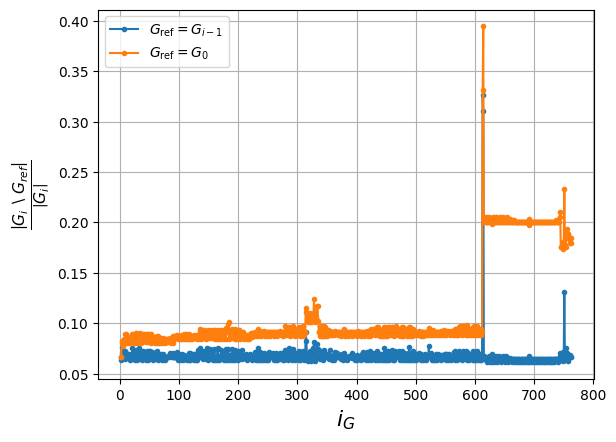

In [9]:
plt.plot(range(1, timestamps.size), differences/graph_sizes[1:], '.-', label=r"$G_\text{ref}=G_{i-1}$")
plt.plot(range(1, timestamps.size), differences_from_first/graph_sizes[1:], '.-', label=r"$G_\text{ref}=G_0$")
plt.grid()
plt.xlabel(r"$i_G$", fontsize=16)
plt.ylabel(r"$\frac{\left| G_{i} \setminus G_{ref} \right|}{\left| G_{i} \right|}$", fontsize=16)
plt.legend()

Text(0, 0.5, '$t$ [min]')

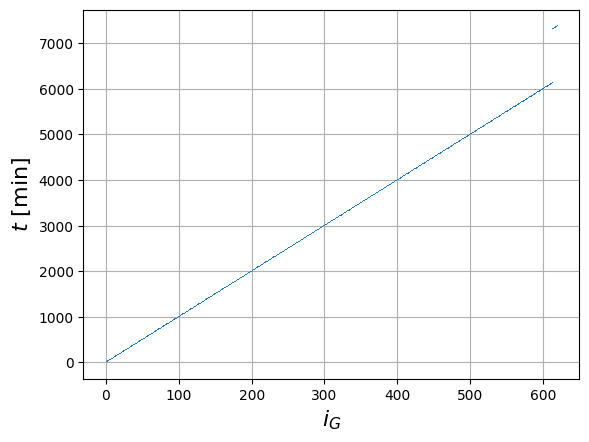

In [121]:
timestamps_int = np.array([int(timestamp.replace("timestamp:", "")) for timestamp in timestamps])
plt.plot((timestamps_int-timestamps_int[0])/1000/60, ',')
plt.grid()
plt.xlabel(r"$i_G$", fontsize=16)
plt.ylabel(r"$t$ [min]", fontsize=16)

In [122]:
from rdflib import Graph

In [123]:
timestamps[1]

np.str_('timestamp:1730280003972')

In [124]:
fname = "query_graphs.txt"
query = read_file(fname).replace("graph1", timestamps[0]).replace("graph2", timestamps[1])

In [125]:
response = perform_query(query)

In [126]:
from SPARQLWrapper.SmartWrapper import Bindings

In [127]:
binding = response.results.bindings[0]
triple_type[binding['s']['type']](binding['s']['value'])

rdflib.term.URIRef('glc:default-scheduler')

In [128]:
def get_graph_from_bindings(bindings):
    g = Graph()

    for binding in bindings: #response.results.bindings:
        g.add((triple_type[binding['s']['type']](binding['s']['value']), triple_type[binding['p']['type']](binding['p']['value']), triple_type[binding['o']['type']](binding['o']['value'])))
    
    return g

In [129]:
fname = "simple_query.txt"
query = read_file(fname).replace("graph1", timestamps[0]) #.replace("graph2", timestamps[1])
response = perform_query(query)

In [130]:
fname = "simple_query.txt"
query2 = read_file(fname).replace("graph1", timestamps[1]) #.replace("graph2", timestamps[1])
response2 = perform_query(query2)

In [131]:
g1 = get_graph_from_bindings(response.results.bindings)
g2 = get_graph_from_bindings(response2.results.bindings)

In [132]:
len(g1 ^ g2) 

1132

In [133]:
def compare_graphs(old_graph, new_graph):
    added_triples = new_graph - old_graph
    removed_triples = old_graph - new_graph

    return added_triples, removed_triples

In [134]:
added_triples, removed_triples = compare_graphs(g1, g2)

In [135]:
len(timestamps)

620

In [136]:
len(g1)

8464

In [137]:
len(added_triples)+len(removed_triples)

1132

In [138]:
(len(added_triples)+len(removed_triples))/len(g1)

0.1337429111531191

In [139]:
size_deltas_from_0 = []
size_deltas_in_between = []

size_g_accum = []

query = read_file(fname).replace("graph1", timestamps[0]) #.replace("graph2", timestamps[1])
response = perform_query(query)
g0 = get_graph_from_bindings(response.results.bindings)
# g1 = get_graph_from_bindings(response.results.bindings)
g_accum = get_graph_from_bindings(response.results.bindings)

for i in range(1, len(timestamps)):
    
    query1 = read_file(fname).replace("graph1", timestamps[i-1])
    response1 = perform_query(query1)
    g1 = get_graph_from_bindings(response1.results.bindings)
    
    query2 = read_file(fname).replace("graph1", timestamps[i]) #.replace("graph2", timestamps[1])
    response2 = perform_query(query2)
    
    g2 = get_graph_from_bindings(response2.results.bindings)
    
    g_accum = g_accum + g2
    
    added_triples_0, removed_triples_0 = compare_graphs(g0, g2)
    added_triples, removed_triples = compare_graphs(g1, g2)
    
    
    size_deltas_from_0.append(len(added_triples_0)+len(removed_triples_0))
    size_deltas_in_between.append(len(added_triples)+len(removed_triples))
    
    size_g_accum.append(len(g_accum))

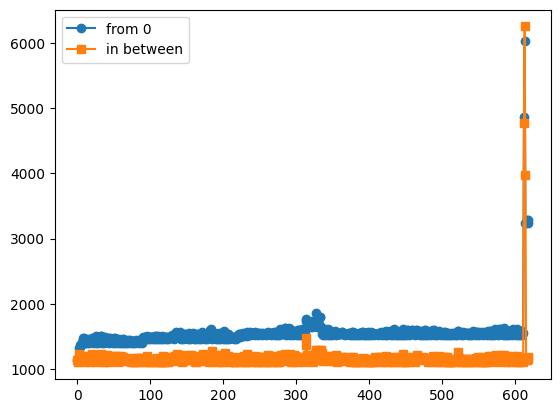

In [140]:
plt.plot(size_deltas_from_0, '-o', label="from 0")
plt.plot(size_deltas_in_between, '-s' ,label="in between")

# plt.plot(np.array(size_g_accum)-len(g0), '-^', label="accum")

plt.legend()

In [141]:
size_deltas_from_0_np = np.array(size_deltas_from_0)
size_deltas_in_between = np.array(size_deltas_in_between)

In [142]:
plt.plot(np.cumsum(size_deltas_from_0_np)/(np.arange(1,44)*len(g0)))
plt.plot(np.cumsum(size_deltas_in_between)/(np.arange(1,44)*len(g0)))



ValueError: operands could not be broadcast together with shapes (619,) (43,) 

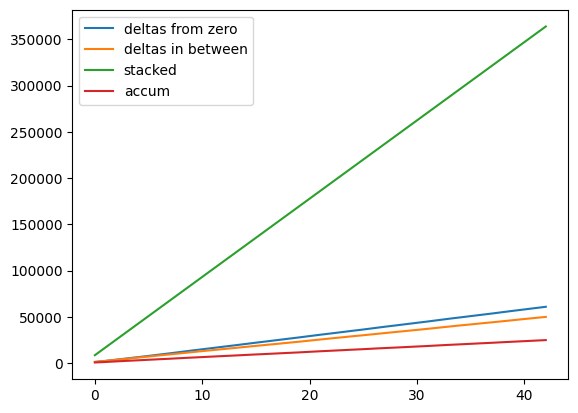

In [96]:
plt.plot(np.cumsum(size_deltas_from_0_np),  label="deltas from zero")
plt.plot(np.cumsum(size_deltas_in_between), label = "deltas in between")
plt.plot(np.arange(1,44)*len(g0), label="stacked")

plt.plot(np.array(size_g_accum)-len(g0),  label="accum")

plt.legend()


In [104]:
fname_node_sparql_query = "node-sparql-query.txt"
node_sparql_query = read_file(fname_node_sparql_query)

node_sparql_response = perform_query(node_sparql_query)

In [106]:
g_node_sparql = get_graph_from_bindings(node_sparql_response.results.bindings)


In [107]:
len(g_node_sparql)

0

In [108]:
node_sparql_response

SearchResponse(head=ResponseHead(vars=['graphURI', 'node', 'measurement', 'measurementName', 'timestamp', 'value', 'unit']), results=ResponseResults(bindings=[]))

In [110]:
query1 = read_file(fname).replace("graph1", timestamps[i-1])
response1 = perform_query(query1)

In [111]:
response1

SearchResponse(head=ResponseHead(vars=['s', 'p', 'o']), results=ResponseResults(bindings=[{'s': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct', 'type': 'uri'}, 'p': {'value': 'glc:hasSubResource', 'type': 'uri'}, 'o': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct.kepler-exporter', 'type': 'uri'}}, {'s': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct', 'type': 'uri'}, 'p': {'value': 'glc:hasID', 'type': 'uri'}, 'o': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct', 'type': 'uri'}}, {'s': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct', 'type': 'uri'}, 'p': {'value': 'glc:hasStatus', 'type': 'uri'}, 'o': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct.Status', 'type': 'uri'}}, {'s': {'value': 'https://kubernetes.local/#monitoring.kepler-lv8ct', 'type': 'uri'}, 'p': {'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'type': 'uri'}, 'o': {'value': 'glc:WorkProducingResource', 'type': 'uri'}}, {'s'

In [152]:
predicate="glc:makes"  #"rdf:type" 
object_="glc:WorkProducingResource"

for s,p,o in g0.triples((None, predicate, None)):
    print(f"Subject: {s}, Predicate: {p}, Object: {o}")